In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv('timeslape.csv')

In [3]:
data.head()


,TimeStamp,Suction_Flow,Suction_Pressure,Discharge_Flow,Discharge_Pressure
0,"May 2, 2024 10:15:00 AM",30565.29487,3141.525228,12768.16850,159.049580
1,"May 11, 2024 12:15:00 AM",31417.94056,3141.482868,12912.05232,160.480662
2,"May 13, 2024 02:45:00 PM",31386.62072,3141.448031,13342.13702,159.134220
3,"May 29, 2024 09:15:00 AM",31148.81990,3141.412044,13359.18280,158.771323
4,"May 27, 2024 08:45:00 AM",30839.26788,3141.381515,13249.81868,158.995348


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3752 entries, 0 to 3751
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TimeStamp           3752 non-null   object 
 1   Suction_Flow        3495 non-null   float64
 2   Suction_Pressure    3751 non-null   float64
 3   Discharge_Flow      3750 non-null   float64
 4   Discharge_Pressure  3750 non-null   float64
dtypes: float64(4), object(1)
memory usage: 146.7+ KB


In [5]:
numeric_data = data[['Suction_Flow', 'Suction_Pressure', 'Discharge_Flow', 'Discharge_Pressure']].dropna()
timestamps = data.loc[numeric_data.index, ['TimeStamp']]


In [6]:
valid_indices = numeric_data.dropna().index.intersection(timestamps.dropna().index)
numeric_data = numeric_data.loc[valid_indices]
timestamps = timestamps.loc[valid_indices]

In [7]:
def kmeans(data, k, max_iterations=100):
    np.random.seed(42)
    centroids = data.sample(n=k).to_numpy()

    def assign_clusters(data, centroids):
        distances = np.linalg.norm(data.to_numpy()[:, None] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    def update_centroids(data, clusters, k):
        return np.array([data[clusters == i].mean(axis=0) if len(data[clusters == i]) > 0 else data.sample(n=1).to_numpy() for i in range(k)])

    for _ in range(max_iterations):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, clusters, k)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    cluster_counts = np.bincount(clusters)
    return centroids, clusters, cluster_counts

In [8]:
k = 3
centroids, clusters, cluster_counts = kmeans(numeric_data, k)

In [9]:
anomalous_clusters = np.where(cluster_counts < (0.1 * len(numeric_data)))[0]
anomalies_indices = np.where(np.isin(clusters, anomalous_clusters))[0] 


In [10]:
data_with_clusters = numeric_data.copy()
data_with_clusters['Cluster'] = clusters

In [11]:
anomalies_with_timestamp = pd.concat([timestamps.iloc[anomalies_indices], numeric_data.iloc[anomalies_indices]], axis=1)
anomalies_with_timestamp['Cluster'] = 'Anomaly'

In [12]:
# pip install xlsxwriter


In [13]:
# Create Excel writer
output_file_path = 'clusters_and_anomalies.xlsx'
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    
    combined_data = pd.concat([timestamps, numeric_data], axis=1)
    combined_data['Cluster'] = clusters
    for cluster in range(k):
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_data = combined_data.iloc[cluster_indices]
        sheet_name = f'Cluster_{cluster + 1}'
        cluster_data.to_excel(writer, sheet_name=sheet_name, index=False)
    
    
    anomalies_with_timestamp.to_excel(writer, sheet_name='Anomalies', index=False)

    
    combined_data['Anomalous'] = combined_data.index.map(lambda idx: 'Anomalous' if idx in anomalies_indices else 'Non-Anomalous')
    combined_data['Cluster'] = combined_data['Cluster'] + 1  # Adjust cluster labels to start from 1
    combined_data.to_excel(writer, sheet_name='Combined_Data', index=False)


In [14]:
combined_data.head()

,TimeStamp,Suction_Flow,Suction_Pressure,Discharge_Flow,Discharge_Pressure,Cluster,Anomalous
0,"May 2, 2024 10:15:00 AM",30565.29487,3141.525228,12768.16850,159.049580,3,Non-Anomalous
1,"May 11, 2024 12:15:00 AM",31417.94056,3141.482868,12912.05232,160.480662,3,Non-Anomalous
2,"May 13, 2024 02:45:00 PM",31386.62072,3141.448031,13342.13702,159.134220,3,Non-Anomalous
3,"May 29, 2024 09:15:00 AM",31148.81990,3141.412044,13359.18280,158.771323,3,Non-Anomalous
4,"May 27, 2024 08:45:00 AM",30839.26788,3141.381515,13249.81868,158.995348,3,Non-Anomalous


In [15]:
print("Cluster Centroids:\n", centroids)
print("\nCluster Sizes:\n", cluster_counts)

Cluster Centroids:
 [[15319.30907848  1570.34448054  6545.37477197    84.3097805 ]
 [15693.49945282  3031.60155974 12954.01200201   126.86560065]
 [31031.79639747  2761.30171671 11227.26085322   146.8125904 ]]

Cluster Sizes:
 [2929  117  447]


In [16]:
from scipy.spatial.distance import pdist, squareform
distances = pdist(centroids, metric='euclidean')
distance_matrix = squareform(distances)

In [17]:
distance_df = pd.DataFrame(
    distance_matrix,
    columns=[f'Cluster_{i+1}' for i in range(len(centroids))],
    index=[f'Cluster_{i+1}' for i in range(len(centroids))]
)

In [18]:
print("Pairwise Distances between Cluster Centroids:")
print(distance_df)

Pairwise Distances between Cluster Centroids:
              Cluster_1     Cluster_2     Cluster_3
Cluster_1      0.000000   6583.899516  16438.509688
Cluster_2   6583.899516      0.000000  15437.567249
Cluster_3  16438.509688  15437.567249      0.000000


In [19]:
distance_df.to_excel(writer, sheet_name='Cluster_Distances')

In [20]:
sil_score = silhouette_score(numeric_data, clusters)
sil_score

0.9001002119470478

C:\Users\hrish\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


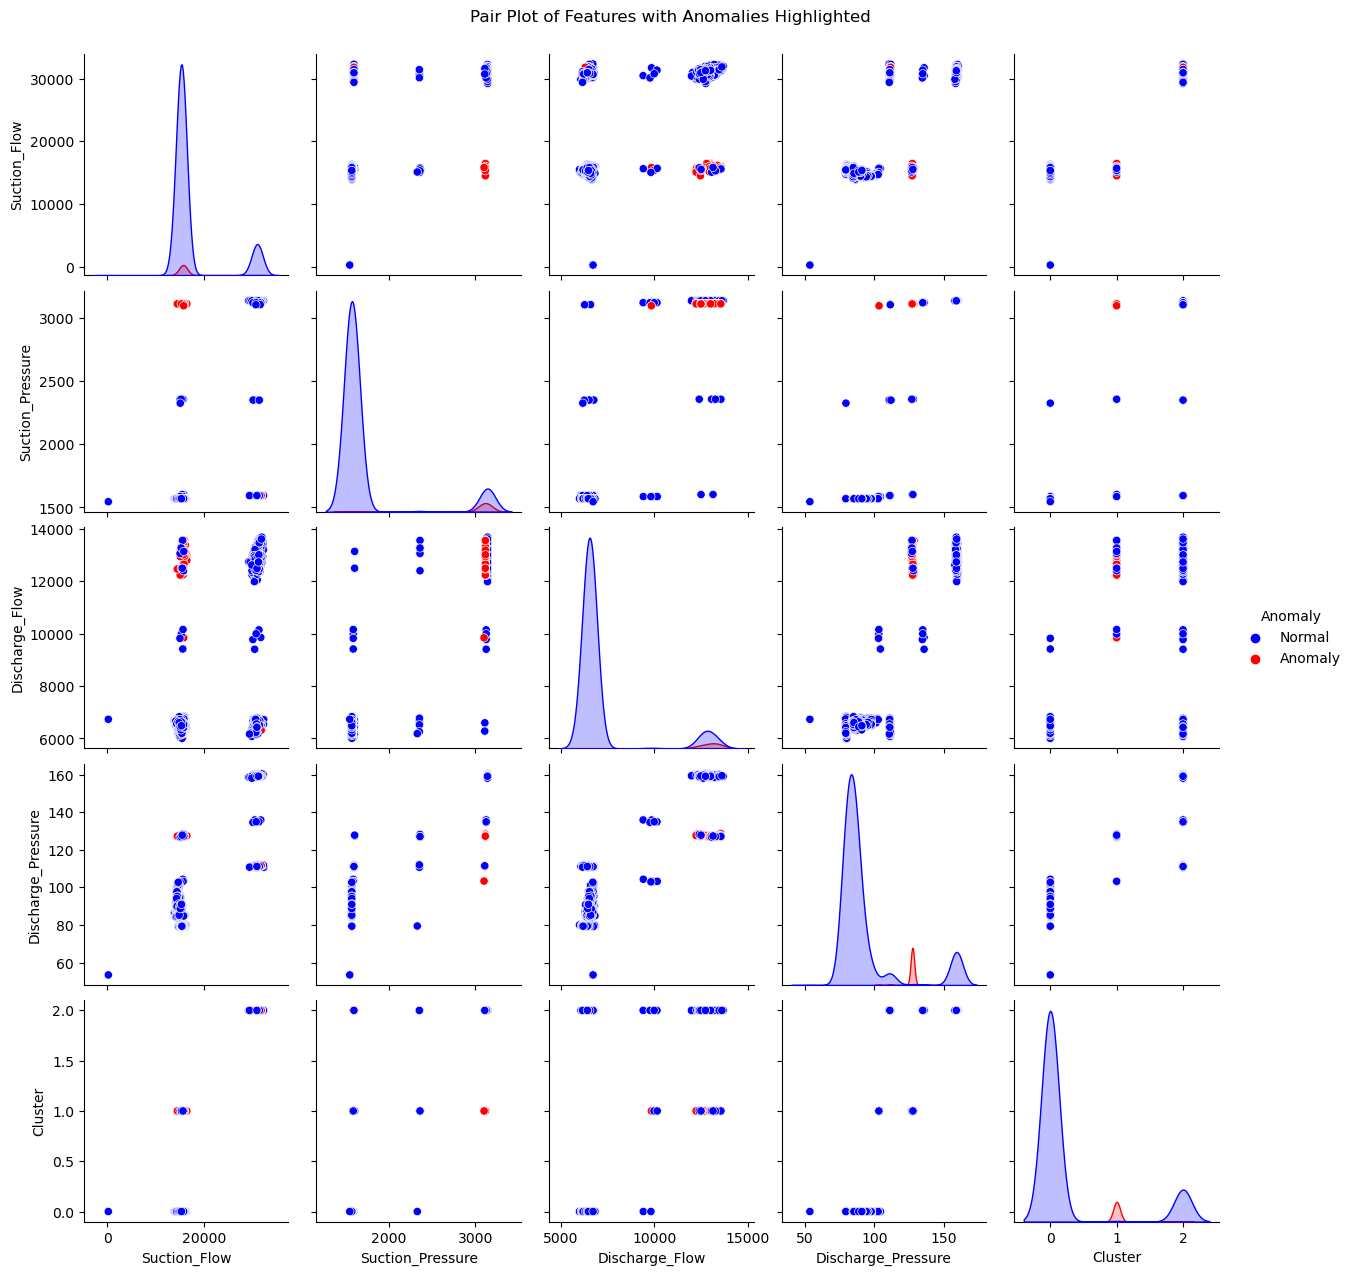

In [21]:
data_with_clusters = numeric_data.copy()
data_with_clusters['Cluster'] = clusters
data_with_clusters['Anomaly'] = data_with_clusters.index.map(lambda idx: 'Anomaly' if idx in anomalies_indices else 'Normal')


sns.pairplot(data_with_clusters, hue='Anomaly', palette={'Normal': 'blue', 'Anomaly': 'red'}, diag_kind='kde')
plt.suptitle('Pair Plot of Features with Anomalies Highlighted', y=1.02)
plt.show()

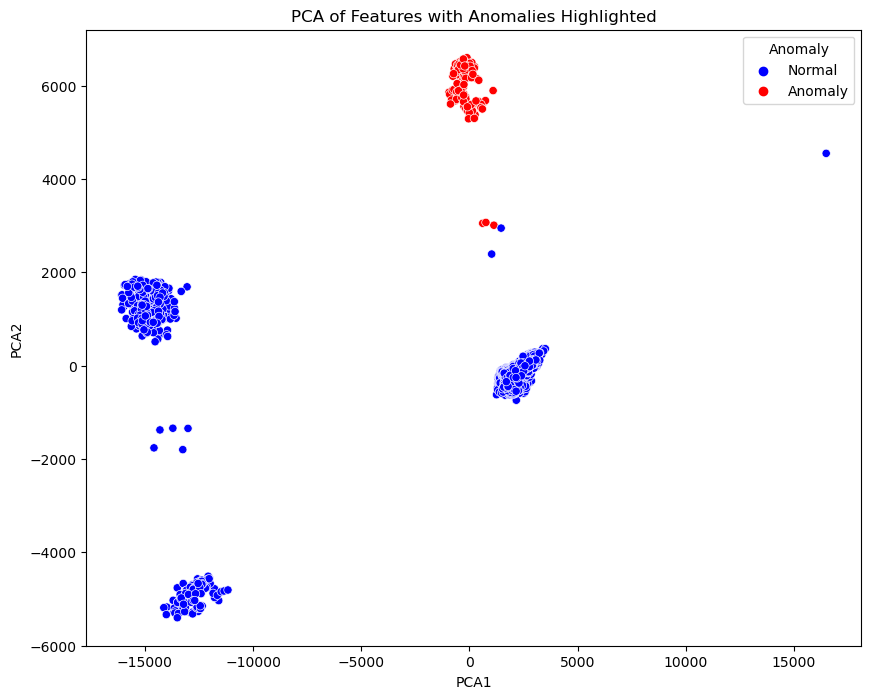

In [22]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_data)


pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters
pca_df['Anomaly'] = pca_df.index.map(lambda idx: 'Anomaly' if idx in anomalies_indices else 'Normal')


plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Anomaly', palette={'Normal': 'blue', 'Anomaly': 'red'})
plt.title('PCA of Features with Anomalies Highlighted')
plt.show()